### Import libraries

In [1]:
import sys
import os
import gc
import numpy as np
import pandas as pd 
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [36]:
from util import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
set_gpu_limit(6)

### Split none onehot encoded data into train and test for categorical embedding

In [5]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_data_merged.csv")
features, y = data.drop("price",axis=1), data.price
X_train, X_test, y_train, y_test = train_test_split(features,y,test_size=0.1,random_state=2020)
X_train,X_dev,y_train,y_dev = train_test_split(X_train,y_train,test_size=0.11,random_state=2020)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99186 entries, 0 to 99185
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   model          99186 non-null  object
 1   price          99186 non-null  int64 
 2   transmission   99186 non-null  object
 3   fuelType       99186 non-null  object
 4   binned_year    99186 non-null  int64 
 5   mil_cat        99186 non-null  int64 
 6   binned_mpg     99186 non-null  int64 
 7   engine_binned  99186 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 6.1+ MB


### We will embed columns model, transmission, and fuelType

--- 

### Garbage collect

In [8]:
gc.collect()
%reset -f out

Flushing output cache (2 entries)


### map categorical features into numeric value based upon train data only
* each input list has following 4 numpy arrays:
  * categorical info for model
  * categorical info for transmission
  * categorical info for fuelType

In [10]:
EMBED_COLS = ["model","transmission","fuelType"]

In [15]:
train_input,dev_input,test_input = cate_embed_process(X_train,X_dev,X_test,EMBED_COLS)

In [32]:
features.fuelType.nunique()

5

In [40]:
BATCH_SIZE = 256 
input_size = features.shape[1]
MAX_EPOCH = 1000
lr = 1e-3
SIZES1 = [128]
size2 = [1024,512,256]
dropouts = [0.3,0.25]
METRICS = ["MAPE","MAE"]

In [46]:
model = embed_model_setup(EMBED_COLS,X_train,SIZES1,size2,dropouts,METRICS)

(None, 1, 50)
(None, 50)
(None, 1, 4)
(None, 4)
(None, 1, 5)
(None, 5)


In [47]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
model_embedding (Embedding)     (None, 1, 50)        9750        input_17[0][0]                   
____________________________________________________________________________________________

In [52]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",
                                        patience=10,verbose=1,restore_best_weights=True)

In [53]:
history = model.fit(train_input,y_train,validation_data=(dev_input,y_dev),epochs=MAX_EPOCH,
                   batch_size=BATCH_SIZE,verbose=1,callbacks=[earlystop])

Epoch 1/1000
311/311 [==============================] - 1s 3ms/step - loss: 5667724.0000 - MAPE: 10.2869 - MAE: 1599.8926 - val_loss: 7962431.5000 - val_MAPE: 9.6286 - val_MAE: 1579.5573
Epoch 2/1000
311/311 [==============================] - 1s 3ms/step - loss: 5644140.0000 - MAPE: 10.2800 - MAE: 1597.1576 - val_loss: 7643864.5000 - val_MAPE: 9.7801 - val_MAE: 1551.7267
Epoch 3/1000
311/311 [==============================] - 1s 3ms/step - loss: 5613356.5000 - MAPE: 10.2682 - MAE: 1594.8116 - val_loss: 7702998.5000 - val_MAPE: 9.8429 - val_MAE: 1567.2228
Epoch 4/1000
311/311 [==============================] - 1s 3ms/step - loss: 5700162.5000 - MAPE: 10.2921 - MAE: 1601.5288 - val_loss: 7731790.0000 - val_MAPE: 9.8700 - val_MAE: 1570.1672
Epoch 5/1000
311/311 [==============================] - 1s 3ms/step - loss: 5634624.5000 - MAPE: 10.2625 - MAE: 1594.0529 - val_loss: 7699575.0000 - val_MAPE: 9.6202 - val_MAE: 1555.3209
Epoch 6/1000
311/311 [==============================] - 1s 3ms/st

In [59]:
model.save("cate_embed_base_model.h5")

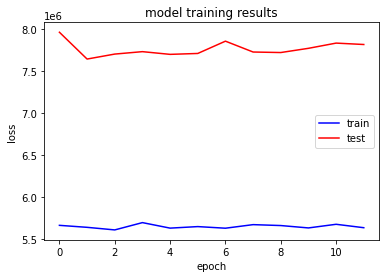

In [55]:
plot_metrics(history,"loss")

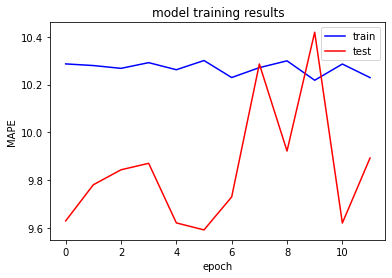

In [56]:
plot_metrics(history,"MAPE")

In [60]:
regression_metrics(model,train_input,y_train,test_input,y_test,256)

,r2_score,rmse,price_diff_abs_max
train,0.951014,2183.166275,524.768584
test,0.941426,2334.561787,206.641376


In [58]:
model = tfk.models.load_model("cate_embed_base_model.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})